In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
torch:  1.11 ; cuda:  1.11.0
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets import load_coco_json
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
%matplotlib inline

from MyTrainer import MyTrainer

In [49]:
!zip -r saved_model

/bin/bash: zip: command not found


In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01 # Set threshold for this model
cfg.MODEL.WEIGHTS = 'output_old/model_final.pth' # Set path model .pth
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
predictor = DefaultPredictor(cfg)

[06/28 08:46:31 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [4]:
dataset_dir = os.path.join('land_segmentation_coco_dataset')
train_dataset_dir = os.path.join(dataset_dir, 'train')
train_images_dir = os.path.join(train_dataset_dir, 'images')
train_annotations_dir = os.path.join(train_dataset_dir, 'land_segmentation_coco.json')
val_dataset_dir = os.path.join(dataset_dir, 'val')
val_images_dir = os.path.join(val_dataset_dir, 'images')
val_annotations_dir = os.path.join(val_dataset_dir, 'land_segmentation_coco.json')

In [5]:
register_coco_instances(name="land_segmentation_train", metadata={}, json_file=train_annotations_dir, image_root=train_images_dir)
register_coco_instances(name="land_segmentation_val", metadata={}, json_file=val_annotations_dir, image_root=val_images_dir)
land_segmentation_metadata = MetadataCatalog.get("land_segmentation_train")
land_segmentation_metadata.thing_colors = [(245,147,49),(178,80,80),(52,209,183),(61,245,61)]
print(land_segmentation_metadata)

Metadata(name='land_segmentation_train', json_file='land_segmentation_coco_dataset/train/land_segmentation_coco.json', image_root='land_segmentation_coco_dataset/train/images', evaluator_type='coco', thing_colors=[(245, 147, 49), (178, 80, 80), (52, 209, 183), (61, 245, 61)])


In [6]:
land_segmentation_metadata = MetadataCatalog.get("land_segmentation_val")
land_segmentation_metadata.thing_colors = [(245,147,49),(178,80,80),(52,209,183),(61,245,61)]
print(land_segmentation_metadata)

Metadata(name='land_segmentation_val', json_file='land_segmentation_coco_dataset/val/land_segmentation_coco.json', image_root='land_segmentation_coco_dataset/val/images', evaluator_type='coco', thing_colors=[(245, 147, 49), (178, 80, 80), (52, 209, 183), (61, 245, 61)])


WARNING [06/28 08:54:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 08:54:55 d2.data.datasets.coco]: Loaded 15679 images in COCO format from land_segmentation_coco_dataset/train/land_segmentation_coco.json
land_segmentation_coco_dataset/train/images/L18B10D2A_crop_416.tif


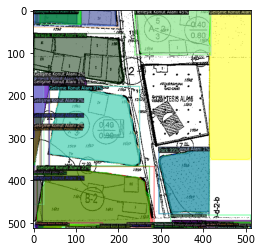



land_segmentation_coco_dataset/train/images/L40B25B2D_crop_1301.jpg


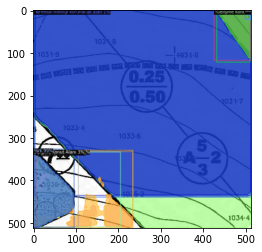



land_segmentation_coco_dataset/train/images/K19C12A2C_crop_762.jpg


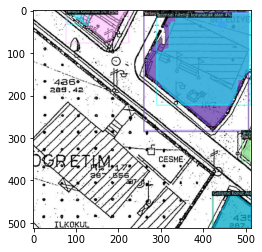

In [9]:
dicts = load_coco_json(train_annotations_dir, train_images_dir, 'land_segmentation_val')
for d in random.sample(dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=land_segmentation_metadata, 
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(d["file_name"])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    print('\n')

In [19]:
def _create_text_labels(classes, scores, class_names, is_crowd=None):
    """
    Args:
        classes (list[int] or None):
        scores (list[float] or None):
        class_names (list[str] or None):
        is_crowd (list[bool] or None):
    Returns:
        list[str] or None
    """
    labels = None
    if classes is not None:
        if class_names is not None and len(class_names) > 0:
            labels = [class_names[i] for i in classes]
        else:
            labels = [str(i) for i in classes]
    if scores is not None:
        if labels is None:
            labels = ["{:.0f}%".format(s * 100) for s in scores]
        else:
            labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
    if labels is not None and is_crowd is not None:
        labels = [l + ("|crowd" if crowd else "") for l, crowd in zip(labels, is_crowd)]
    return labels

In [29]:
class GenericMask:
    """
    Attribute:
        polygons (list[ndarray]): list[ndarray]: polygons for this mask.
            Each ndarray has format [x, y, x, y, ...]
        mask (ndarray): a binary mask
    """

    def __init__(self, mask_or_polygons, height, width):
        self._mask = self._polygons = self._has_holes = None
        self.height = height
        self.width = width

        m = mask_or_polygons
        if isinstance(m, dict):
            # RLEs
            assert "counts" in m and "size" in m
            if isinstance(m["counts"], list):  # uncompressed RLEs
                h, w = m["size"]
                assert h == height and w == width
                m = mask_util.frPyObjects(m, h, w)
            self._mask = mask_util.decode(m)[:, :]
            return

        if isinstance(m, list):  # list[ndarray]
            self._polygons = [np.asarray(x).reshape(-1) for x in m]
            return

        if isinstance(m, np.ndarray):  # assumed to be a binary mask
            assert m.shape[1] != 2, m.shape
            assert m.shape == (
                height,
                width,
            ), f"mask shape: {m.shape}, target dims: {height}, {width}"
            self._mask = m.astype("uint8")
            return

        raise ValueError("GenericMask cannot handle object {} of type '{}'".format(m, type(m)))

    @property
    def mask(self):
        if self._mask is None:
            self._mask = self.polygons_to_mask(self._polygons)
        return self._mask

    @property
    def polygons(self):
        if self._polygons is None:
            self._polygons, self._has_holes = self.mask_to_polygons(self._mask)
        return self._polygons

    @property
    def has_holes(self):
        if self._has_holes is None:
            if self._mask is not None:
                self._polygons, self._has_holes = self.mask_to_polygons(self._mask)
            else:
                self._has_holes = False  # if original format is polygon, does not have holes
        return self._has_holes

    def mask_to_polygons(self, mask):
        # cv2.RETR_CCOMP flag retrieves all the contours and arranges them to a 2-level
        # hierarchy. External contours (boundary) of the object are placed in hierarchy-1.
        # Internal contours (holes) are placed in hierarchy-2.
        # cv2.CHAIN_APPROX_NONE flag gets vertices of polygons from contours.
        mask = np.ascontiguousarray(mask)  # some versions of cv2 does not support incontiguous arr
        res = cv2.findContours(mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        hierarchy = res[-1]
        if hierarchy is None:  # empty mask
            return [], False
        has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
        res = res[-2]
        res = [x.flatten() for x in res]
        # These coordinates from OpenCV are integers in range [0, W-1 or H-1].
        # We add 0.5 to turn them into real-value coordinate space. A better solution
        # would be to first +0.5 and then dilate the returned polygon by 0.5.
        res = [x + 0.5 for x in res if len(x) >= 6]
        return res, has_holes

    def polygons_to_mask(self, polygons):
        rle = mask_util.frPyObjects(polygons, self.height, self.width)
        rle = mask_util.merge(rle)
        return mask_util.decode(rle)[:, :]

    def area(self):
        return self.mask.sum()

    def bbox(self):
        p = mask_util.frPyObjects(self.polygons, self.height, self.width)
        p = mask_util.merge(p)
        bbox = mask_util.toBbox(p)
        bbox[2] += bbox[0]
        bbox[3] += bbox[1]
        return bbox

In [36]:
predictions = outputs["instances"]
output_height = 1024
output_width = 1024
metadata = land_segmentation_metadata
boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
scores = predictions.scores if predictions.has("scores") else None
classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
labels = _create_text_labels(classes, scores, metadata.get("thing_classes", None))
keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

if predictions.has("pred_masks"):
    masks = np.asarray(predictions.pred_masks.cpu())
    masks = [GenericMask(x, output_height, output_width) for x in masks]
else:
    masks = None

In [43]:
print(masks[1].polygons)

[array([935.5, 858.5, 934.5, ..., 858.5, 936.5, 858.5])]


In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("land_segmentation_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "land_segmentation_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [06/28 08:47:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 08:47:16 d2.data.datasets.coco]: Loaded 485 images in COCO format from land_segmentation_coco_dataset/val/land_segmentation_coco.json
[06/28 08:47:16 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| Tarımsal ni.. | 115          | Gelişme Kon.. | 407          | Yerleşik Ko.. | 459          |
|     Park      | 239          |               |              |               |              |
|     total     | 1220         |               |              |               |              |
[06/28 08:47:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_st